## Quotations indicate the career success of public figures
**ChillDataGroup: Zihan Wu, Yinhao Wang, Yihang Chen**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load QuoteBank Dataset
We refer to the pipeline provided in Google Colab to load the quotations from 2015 to 2020.

Due to the large size of data, when loading them, we just load the data said by the senate election since 2015 candidates. The dataset for senate elections is obtained from MIT Election Data and Science Lab [1].

We also provide the codes for loading these senate candidate quotations below, but those are run ahead in google colab (takes around 30min for each year's data). We did not re-run them here. It contains the senate election results for all candidates

[1] MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2020", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V5.

In [2]:
# Pipeline obtained from the course google colab
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [3]:
# Load the Senate Election Result data 
import pandas as pd
senate_file = 'SenateData/1976-2020-senate.csv'
senate_election = pd.read_csv(senate_file, encoding= 'unicode_escape')
senate_election.sample(4) # demonstrate the format of election data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
2629,2010,OHIO,OH,39,31,24,US SENATE,statewide,gen,False,DANIEL H. LABOTZ,SOCIALIST,False,total,26454,3815098,False,20210114,OTHER
654,1986,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,NaN,NaN,True,total,239,180801,False,20210114,OTHER
3594,2020,SOUTH CAROLINA,SC,45,57,48,US SENATE,statewide,gen,False,NaN,NaN,True,total,2294,2515104,False,20210114,OTHER
2293,2008,ARKANSAS,AR,5,71,42,US SENATE,statewide,gen,False,MARK L. PRYOR,DEMOCRAT,False,total,804678,1011754,False,20210114,DEMOCRAT


Here, we only choose the candidate running for elections since 2016, because the supported Quotebank data goes back to 2015

In [4]:
# Load the names of candidates since 2016
# The NaN names are dropped, and repeated names are dropped
def delete_middle_name(name): # delete middle name
  name_split = name.upper().split()
  if len(name_split) > 2:
    senate_delete_middle_name = name_split[0] + ' ' + name_split[-1]
    return senate_delete_middle_name
  return name

# To address the variation of names, we use this function to determine whether the speaker name matches the first and 
# last name of any senate candidates. In this way, we can find speakers with different name writing style like:
# 'Senate Lindsey Graham', 'Lindsey Olin Graham', 'Lindsey O. Graham' (they all indicate the same candidate)

# The function below takes in a speaker name and a list of senate names (already split into first and last name)
# It returns a boolean whether the speaker is a senate, and the name of senate (in the form of first + last name) if true
def isSenate(name,senate_names):
  name_set = set(name.upper().split())
  for i in range(len(senate_names)):
    if senate_names[i] <= name_set:
      return (True, i)
  return (False, None)

senate_candidates = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed'])['candidate'].unique()
senate_candidates_splitted = list(map(lambda senate: set(delete_middle_name(senate).split()), senate_candidates))
senate_candidates_splitted[1:10]

[{'RICHARD', 'SHELBY'},
 {'JOE', 'MILLER'},
 {'GIANOUTSOS', 'TED'},
 {'METCALFE', 'RAY'},
 {'MARGARET', 'STOCK'},
 {'BRECK', 'CRAIG'},
 {'LISA', 'MURKOWSKI'},
 {'ANTHONY', 'CAMBONI'},
 {'ANN', 'KIRKPATRICK'}]

In [5]:
#Sanity Check: all names at least have a first and last name
for split in senate_candidates_splitted:
    assert(len(split) > 1)
print('there are total {} names'.format(len(senate_candidates_splitted)))

there are total 439 names


**We do not run the cell below because takes too long.** We have run those on google colab to load the quotation data we need

In [ ]:
# Load each year's data, filtering out the quotations said by senates
# We have considered the different writing styles of name. We extract the quote as long as the speaker has the same
# first name and last name as a senate
import bz2
import json

path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2' 
path_to_out = '/content/drive/MyDrive/MyQuoteBank/quotes-{}-senates-said.json.bz2'

for year in range(2015, 2021):
  print('... Start reading quotations in year ' + str(year))
  with bz2.open(path_to_file.format(year), 'rb') as s_file:
      with bz2.open(path_to_out.format(year), 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              issenate = isSenate(instance['speaker'], senate_candidates_splitted)
              if issenate[0]:
                instance['speaker'] = senate_candidates[issenate[1]] # use name from the "1976-2020-senate.csv" as the standard name.
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

# Load each year's data, filtering out the quotations that mention senates
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2'
path_to_out = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention.json.bz2'

senate_candidates = list(map(lambda x:x.title(), senate_candidates))

for year in range(2016,2021):
    print('... Start processing quotations in year {}'.format(year))
    with bz2.open(path_to_file.format(year), 'rb') as s_file:
        with bz2.open(path_to_out.format(year), 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)
                is_senate = isSenate(instance['quotation'], senate_candidates_splitted)
                if is_senate[0]:
                    instance['mention']=senate_candidates[is_senate[1]]
                    urls = instance['urls'] # extracting list of links
                    domains = []
                    for url in urls:
                        tld = get_domain(url)
                        domains.append(tld)
                    instance['domains'] = domains # updating the sample with domain name
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
    print('... End processing quotations in year {}'.format(year))

## 1. Process Senate Candidate Data
**1.1** In this section, we load the information of senate candidates (since 2016) and their election information.

In [6]:
# First, we get the election information of the candidates since 2016 (again, we drop NaN and repeated names)
candidate_info = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed']).drop_duplicates(subset=['candidate'], ignore_index=True)

In [7]:
# Load the stored quotations said by senate candidates since 2015 (by year)
senate_quote_20 = pd.read_json('SenateData/quotes-2020-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_19 = pd.read_json('SenateData/quotes-2019-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_18 = pd.read_json('SenateData/quotes-2018-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_17 = pd.read_json('SenateData/quotes-2017-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_16 = pd.read_json('SenateData/quotes-2016-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_15 = pd.read_json('SenateData/quotes-2015-senates-said.json.bz2', lines=True, compression='bz2')

In [8]:
# Concatenate data across all years and display the format of quotation data
annual_frames = [senate_quote_15, senate_quote_16, senate_quote_17, senate_quote_18, senate_quote_19, senate_quote_20]
candidate_quotes = pd.concat(annual_frames).reset_index()
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
524086,37434,2019-07-31-023617,I don't have any issue with these fuels or tec...,Joni Ernst,[Q13475242],2019-07-31 13:21:52,1,"[[Joni Ernst, 0.9054], [None, 0.0946]]",[https://www.rollcall.com/news/congress/highwa...,E,[com]
413648,125748,2018-10-28-035016,I've been a conservative for long before Donal...,Ben Sasse,[Q16192221],2018-10-28 19:41:31,1,"[[Ben Sasse, 0.7719], [None, 0.2223], [Preside...",[http://thegazette.com/subject/opinion/staff-c...,E,[com]
70579,70579,2016-01-28-000304,"for seven years, we've had a president in the ...",Ted Cruz,[Q2036942],2016-01-28 01:02:39,1,"[[Ted Cruz, 0.8375], [None, 0.1317], [David Br...",[http://www.politicususa.com/2016/01/27/anoint...,E,[com]
343668,55768,2018-01-30-140847,We could actually unify families. To me that s...,John Cornyn,[Q719568],2018-01-30 11:00:35,1,"[[John Cornyn, 0.9277], [None, 0.0602], [Dick ...",[http://talkingpointsmemo.com/dc/gop-leaders-b...,E,[com]


Since QuoteBank may extract different number of total quotes at different time. An increase in quotations may just be caused by an increase of quotes extracted by Quotebanks. So, we use the total quotation number in QuoteBank to normalize our data

In [10]:
# read the quote number data for each month

import csv
with open('SenateData/quote_num.csv','r') as inFile:
    reader = csv.DictReader(inFile)
    for row in reader:
        quote_num = dict(row)
quote_num = pd.Series({k:int(v) for k, v in quote_num.items()})
quote_num

2015-01    1661137
2015-02    1659518
2015-03    1867911
2015-04    1522315
2015-05    1136152
            ...   
2019-12    1565321
2020-01    1732238
2020-02    1599019
2020-03    1323347
2020-04     589845
Length: 64, dtype: int64

In [12]:
# we use 10^6/total_quote_num as normalize factor

candidate_quotes['normalize_factor'] = candidate_quotes['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes['normalize_quotes'] = candidate_quotes['numOccurrences']*candidate_quotes['normalize_factor']
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes
451973,164073,2018-10-05-037194,I just don't have any evidence it was Brett Ka...,James Lankford,[Q45940],2018-10-05 10:00:12,2,"[[James Lankford, 0.9308], [None, 0.0649], [Br...",[http://mobile.newsok.com/article/5610676/okla...,E,"[com, com]",0.427106,0.854212
69145,69145,2016-09-22-108117,the American people have a right to know wheth...,Ben Cardin,[Q723295],2016-09-22 20:56:21,2,"[[Ben Cardin, 0.8199], [None, 0.1357], [Debbie...",[http://ijr.com/2016/09/698715-senate-democrat...,E,"[com, com]",0.395064,0.790129
413614,125714,2018-01-23-023189,Everybody has input. Everybody trusts everybod...,Joe Manchin,[Q538868],2018-01-23 15:30:00,52,"[[Joe Manchin, 0.7827], [None, 0.1973], [Angus...",[http://timescolonist.com/a-moment-for-moderat...,E,"[com, com, com, com, com, com, com, com, com, ...",0.402250,20.916985
369655,81755,2018-04-29-041180,know they are not alone and there are resource...,Tammy Baldwin,[Q40628],2018-04-29 06:00:00,1,"[[Tammy Baldwin, 0.77], [None, 0.23]]",[http://www.thonline.com/news/tri-state/articl...,E,[com],0.386958,0.386958


**1.2** We group the total number of quotations by speaker and dates. By doing so, we can visualize the change of quoted numbers as time goes on. Below, we take Bernie Sanders as an example.

In [13]:
# Clean the names by taking only upper case
# Group the candidate total number of normalized quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_quotes_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_byday

speaker          date_only 
AARON JAMES      2016-02-18    5.757202
                 2016-05-10    0.877068
                 2016-05-12    0.877068
                 2016-05-18    4.823876
                 2016-05-25    0.877068
                                 ...   
ZAK RINGELSTEIN  2018-10-30    5.125275
                 2018-11-01    2.381878
                 2018-11-05    0.476376
                 2018-11-07    0.476376
                 2019-03-21    0.503878
Name: normalize_quotes, Length: 79165, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

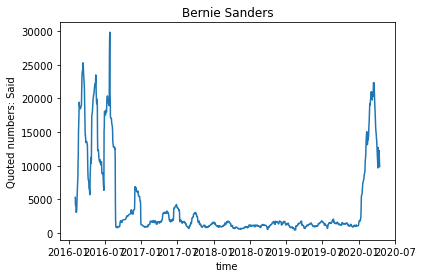

In [14]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Said')
plt.title('Bernie Sanders')

**1.3** We compute the total number of quotations until their election. The election dataset only contains the year of election. However, since the U.S. Senate elections always take place in the first week of November, we just compute the total number of quotations until November.1st of the election year.

In [31]:
# Add the election day corresponding to each candidate speaker
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes['election_day'] = candidate_quotes['speaker'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes['election_day'] = pd.to_datetime(candidate_quotes['election_day'])

In [32]:
# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

In [33]:
# We group the number of quotations by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

Pearson coefficient: 0.6483833179884129, p value: 7.57506251452068e-23


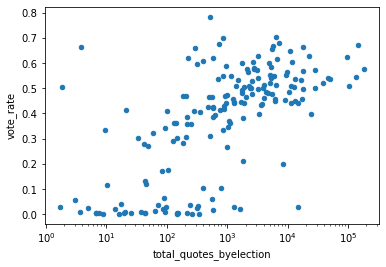

In [34]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is a positive correlation between quotations and vote_rate with p value < 0.05. The more a candidate was quoted before the election, the higher the voting rate he or she got.

**1.4** We can also apply the analysis on quotations that mention senates.

In [20]:
# Load the stored quotations mention senate candidates since 2015 (by year)
senate_quote_20_mention = pd.read_json('SenateData/quotes-2020-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_19_mention = pd.read_json('SenateData/quotes-2019-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_18_mention = pd.read_json('SenateData/quotes-2018-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_17_mention = pd.read_json('SenateData/quotes-2017-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_16_mention = pd.read_json('SenateData/quotes-2016-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_15_mention = pd.read_json('SenateData/quotes-2015-senates-mention.json.bz2', lines=True, compression='bz2')

In [21]:
# Concatenate data across all years and display the format of quotation data
annual_frames_mention = [senate_quote_15_mention, senate_quote_16_mention, senate_quote_17_mention, senate_quote_18_mention, senate_quote_19_mention, senate_quote_20_mention]
candidate_quotes_mention = pd.concat(annual_frames_mention)
candidate_quotes_mention.sample(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains
2178,2018-02-08-048914,I just wanted to focus on Heidi Heitkamp and t...,None,[],2018-02-08 22:35:42,4,"[[None, 0.5452], [Gary Emineth, 0.3325], [Tom ...",[http://kron4.com/ap/north-dakota-us-senate-ca...,E,Heidi Heitkamp,"[com, com, com, com]"
4040,2019-08-03-006875,Does it take that? Or can Elizabeth Warren run...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2019-08-03 01:10:39,1,"[[Chris Matthews, 0.8645], [None, 0.1044], [Pr...",[https://www.lifezette.com/2019/08/chris-matth...,E,Elizabeth A. Warren,[com]
17630,2018-04-11-126405,"They are against each other, but if Paul Ryan ...",Meghan McCain,[Q461063],2018-04-11 18:24:29,1,"[[Meghan McCain, 0.6212], [None, 0.2707], [Joy...",[https://www.washingtonexaminer.com/news/megha...,E,Mitt Romney,[com]
10194,2017-04-25-069384,It's a great day in Georgia now that Senator D...,Doug Middleton,[Q27979046],2017-04-25 17:06:28,1,"[[Doug Middleton, 0.8081], [None, 0.1919]]",[http://chattanoogan.com/2017/4/25/346799/Sena...,E,David A. Perdue,[com]


In [ ]:
# find the mentioned senator of each quotation 
# DO NOT RUN with the new Dataset!
senate_candidates = list(map(lambda x:x.title(), senate_candidates))
candidate_quotes_mention['mention']=candidate_quotes_mention['quotation'].map(lambda x:np.array(senate_candidates)[np.array(list(k in x for k in senate_candidates))][0])
candidate_quotes_mention.head(4)

In [24]:
# format the date
candidate_quotes_mention['date_only'] = candidate_quotes_mention['date'].dt.date
# change the name to upper format
candidate_quotes_mention['mention'] = candidate_quotes_mention['mention'].str.upper()

# Normalize the quotes
candidate_quotes_mention['normalize_factor'] = candidate_quotes_mention['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes_mention['normalize_quotes'] = candidate_quotes_mention['numOccurrences']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes
714,2016-05-04-066467,Marco Rubio sure isn't acting like a guy who h...,None,[],2016-05-04 12:39:47,1,"[[None, 0.5752], [Ted Cruz, 0.2212], [Marco Ru...",[http://www.politico.com/tipsheets/huddle/2016...,E,MARCO RUBIO,[com],2016-05-04,0.438534,0.438534
667,2016-04-28-031572,have endorsed and have sought to get other per...,None,[],2016-04-28 03:11:20,1,"[[None, 0.7267], [Phyllis Schlafly, 0.1625], [...",[http://www.wnd.com/2016/04/phyllis-schlafly-i...,E,TED CRUZ,[com],2016-04-28,0.939819,0.939819
3105,2015-09-25-068313,"Myself and Steve [ Bodow, Daily Show producer ...",Trevor Noah,[Q7839350],2015-09-25 16:41:18,1,"[[Trevor Noah, 0.9184], [None, 0.0816]]",[http://feeds.ew.com/~r/entertainmentweekly/tv...,E,RAND PAUL,[com],2015-09-25,0.447555,0.447555
6004,2016-05-12-000442,"[ MMA pro ] Aaron Lacey and David Lord, my pri...",Chris Young,"[Q2964901, Q2964905, Q2964906, Q47541480, Q510...",2016-05-12 12:52:42,1,"[[Chris Young, 0.9287], [None, 0.0713]]",[http://bangordailynews.com/2016/05/12/sports/...,E,AARON DAY,[com],2016-05-12,0.438534,0.438534
6689,2016-04-29-041772,I remember Tony Romo sat in the office with me...,Jerry Jones,"[Q1280022, Q16643824, Q25190360]",2016-04-29 16:26:57,1,"[[Jerry Jones, 0.6771], [None, 0.1683], [Tony ...",[http://www.star-telegram.com/sports/nfl/dalla...,E,BILL BLEDSOE,[com],2016-04-29,0.939819,0.939819


In [26]:
# obtain normalized quotations by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16    0.601997
                  2015-08-04    0.473512
                  2015-12-11    0.955093
                  2017-02-12    2.080072
                  2017-05-28    0.401338
                                  ...   
WILLIE L. WILSON  2019-03-30    0.503878
                  2019-07-16    0.668486
                  2019-11-04    0.542426
ZAK RINGELSTEIN   2018-06-22    0.482000
                  2018-10-24    0.427106
Name: normalize_quotes, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

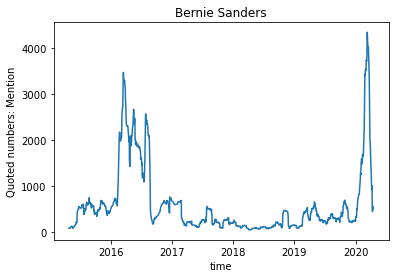

In [27]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

In [28]:
# Add the election day corresponding to each candidate mentioned
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes_mention['mention']=candidate_quotes_mention.mention.map(lambda x:x.upper())
candidate_quotes_mention['election_day'] = candidate_quotes_mention['mention'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes_mention['election_day'] = pd.to_datetime(candidate_quotes_mention['election_day'])
candidate_quotes_mention.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day
0,2015-05-17-016225,I really like Bernie Sanders and his policies ...,None,[],2015-05-17 07:09:22,1,"[[None, 0.81], [Bernie Sanders, 0.19]]",[http://dailykos.com/story/2015/05/15/1384917/...,E,BERNIE SANDERS,[com],2015-05-17,0.880164,0.880164,2018-11-01
1,2015-08-25-018582,Elizabeth Warren does have a thumb on the puls...,Bakari Sellers,[Q4849014],2015-08-25 10:02:35,4,"[[Bakari Sellers, 0.8813], [None, 0.1075], [El...",[http://www.kspr.com/news/politics/does-elizab...,E,ELIZABETH A. WARREN,"[com, com, com, com]",2015-08-25,0.473512,1.894046,2018-11-01
2,2015-03-11-040221,I'll invoke the marital privilege on some of i...,Mike Coffman,[Q547218],2015-03-11 17:09:31,1,"[[Mike Coffman, 0.4786], [None, 0.3104], [Tom ...",[http://www.huffingtonpost.com/jason-salzman/r...,E,CORY GARDNER,[com],2015-03-11,0.535357,0.535357,2020-11-01
3,2015-09-24-081451,Richard Burr truly is North Carolina's `Invisi...,None,[],2015-09-24 02:04:45,1,"[[None, 0.7571], [Richard Burr, 0.182], [Paul ...",[http://www.wcti12.com/news/Ross-leaves-job-po...,E,RICHARD BURR,[com],2015-09-24,0.447555,0.447555,2016-11-01


Pearson coefficient: 0.5320764453359699, p value: 1.1343252830666171e-22


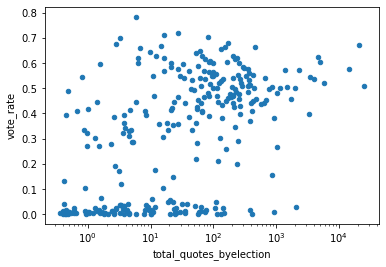

In [35]:
from scipy.stats import pearsonr

# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

# We group the number of normalized quotations before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is also a positive correlation between number of mentioned quotations and vote_rate with p value < 0.05.

## 2. Weigh the quotations by readership
We are aware of the different reading statistics of different media. We try to weigh the quotations by the readership of the source media.

**A problem of QuoteBank noticed when parsing url**: some urls are list of list of urls, like: [['url_a', 'url_b'], 'url_c', 'url_d']

**2.1** First, we sample 20k quotes and look at the source media of those quotations. This would give us a feel of how much media is covered by QuoteBank and which media appear most often.

In [22]:
# sample 20k quotes and see where published
sample = candidate_quotes.sample(20000)
total_domains = []
for i in sample.index:
    urls = sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        if isinstance(url, list):
            for url_ in url:
                total_domains.append(get_tld(url_, as_object=True).domain) # when it is a list, the multiply urls point to the same website
        else:
            total_domains.append(get_tld(url, as_object=True).domain)

**DONOT rerun the below two cells, in case the distribution changes!**

In [23]:
# Count the frequency of media occurences in quotation dataset
from collections import Counter
domain_count = Counter(total_domains).most_common()
print("----top 30 news agency/publisher:\n ", domain_count[0:30])
print('----number of news agency covered:', len(domain_count))


----top 30 news agency/publisher:
  [('krmg', 2173), ('news965', 1716), ('wokv', 1272), ('msn', 1234), ('breitbart', 1081), ('thehill', 1032), ('businessinsider', 1004), ('washingtonexaminer', 980), ('yahoo', 929), ('washingtontimes', 900), ('cnn', 845), ('einnews', 838), ('foxnews', 787), ('cbsnews', 756), ('wsbradio', 745), ('washingtonpost', 597), ('newsmax', 582), ('politico', 575), ('sfgate', 571), ('nbcnews', 532), ('nytimes', 506), ('huffingtonpost', 494), ('kdhnews', 474), ('startribune', 444), ('news12', 443), ('salon', 402), ('wftv', 400), ('abc-7', 396), ('rollcall', 379), ('indiatimes', 359)]
----number of news agency covered: 4246


Among 20k samples, there are over 4000 different website domains, indicating a sufficiently wide coverage of media. So the quotations can be an indicator of public exposure. Besides, we observe an exponential decrease of counts in the database.

Text(0.5, 0, 'occurences in sampled quote data')

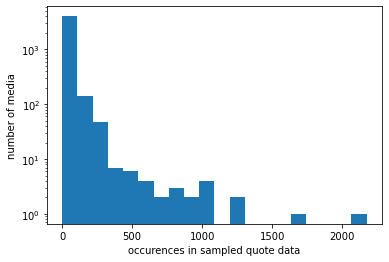

In [24]:
# Plot the histogram characterizing the frequency of each media appearing
_, y_counts = zip(*domain_count)
plt.hist(y_counts, bins=20)
plt.yscale('log')
plt.ylabel('number of media')
plt.xlabel('occurences in sampled quote data')

In [24]:
# Randomly sample 10 other media, to be used for estimating the rest readership
media_ind = np.random.randint(31, len(domain_count), size=10)
print("10 randomly selected news agency/publisher except the top 30:\n ", [domain_count[i] for i in media_ind])

10 randomly selected news agency/publisher except the top 30:
  [('localsyr', 117), ('theadanews', 4), ('metro', 113), ('greenfieldreporter', 6), ('newswest9', 160), ('politic365', 1), ('all4women', 3), ('wxxinews', 67), ('daijiworld', 3), ('pakobserver', 5)]


The distribution is heavy-tailed, with only a few big media like CNN and Fox News occurring frequently. Most media occurs no more than 1.5% among all quotations. So, we think it is sufficient to just weigh the quotations extracted from those frequently occurring media. Moreover, it is very difficult to automatically find media's reading statistics (or other indicators of popularity) just based on the url major domain name. We could not think of a way to do so. Neither could we find an open dataset helping us. Therefore, we decide to manually look up the readership of those top 30 new agencies. For the rest media, we will sample 10 media from them and manually look up the reading statistics. We will take the average readership of those 10 media to represent the readership of the rest media. This will take up some time, so we plan to finish those manual work in the following weeks (see proposed timeline). As a result, we do not include any exposure level (quotation weighted by media readership) in Milestone 2. Instead, we just use the number of quotations (assuming all media offer the same public exposure).

**2.2** We manually search the total website visits of top 30 news agencies of the 10 randomly selected agencies among the rest.

In [36]:
weight_file = 'SenateData/WebsiteVisit.csv'
weight_df = pd.read_csv(weight_file)
weight_df # demonstrate the format of election data

,webdomain,agency,total_view_in_US,audience,source
0,KRMG,KRMG,0.11,0.033,https://webrate.org/site/krmg.com/
1,news965,WBDO,NaN,NaN,default
2,wokv,WOKV,0.09,0.046,https://webrate.org/site/wokv.com/
3,msn,MSN,323.98,194.400,default
4,breitbart,Breitbart,42.19,40.730,default
5,thehill,The Hill,42.07,23.000,default
6,businessinsider,Business Insider,58.93,53.250,default
7,washingtonexaminer,Washington Examiner,13.32,9.230,default
8,yahoo,Yahoo,85.03,17.900,https://cnnpressroom.blogs.cnn.com/2021/07/19/...
9,washingtontimes,Washington Times,3.77,2.960,default


**TO DO:** get real data for random_view, discuss whether to add another for mention data

In [38]:
# Fill the NaN value by median (which avoid effect from outliers)
weight_df.loc[:, ['total_view_in_US', 'audience']] = weight_df[['total_view_in_US', 'audience']].fillna(weight_df[['total_view_in_US', 'audience']].median())
# Get the view for randomly selected agency
random_view = 0.2

In [41]:
# assign weights to quotes
weight_dict = dict(zip(weight_df['webdomain'], weight_df['total_view_in_US']))
n_hit = 0
for i in candidate_quotes.index:
    urls = candidate_quotes.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        if isinstance(url, list):
            for url_ in url:
                webdomain = get_tld(url_, as_object=True).domain # when it is a list, the multiply urls point to the same website
                if webdomain in weight_dict.keys():
                    weight_ = weight_ + weight_dict[webdomain]
                    n_hit = n_hit + 1
                else:
                    weight_ = weight_ + random_view
        else:
            webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
            if webdomain in weight_dict.keys():
                weight_ = weight_ + weight_dict[webdomain]
                n_hit = n_hit + 1
            else:
                weight_ = weight_ + random_view
    candidate_quotes.at[i,'views'] = weight_ 
print('we found {} numbers of quotation occurrences from top 30'.format(n_hit))

we found 585803 numbers of quotation occurrences from top 30


In [44]:
# Normalize views as well 
candidate_quotes['normalize_views'] = candidate_quotes['views']*candidate_quotes['normalize_factor']
candidate_quotes.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views
68540,68540,2016-06-03-000682,"is to bring people together,",BERNIE SANDERS,[Q359442],2016-06-03 23:44:00,2,"[[Bernie Sanders, 0.8176], [None, 0.1741], [Hi...",[http://blogs.alternet.org/election-2016/sande...,E,"[org, com]",15.198954,30.397909,2016-06-03,2018-11-01,10.01,152.141533
52698,52698,2016-07-08-081227,Strengthening Congress so that policymaking is...,MIKE LEE,"[Q21064126, Q30122331, Q55622025, Q627098, Q68...",2016-07-08 15:52:04,1,"[[Mike Lee, 0.5791], [Sheldon Whitehouse, 0.38...",[https://www.law.upenn.edu/live/news/6329-penn...,E,[edu],0.452054,0.452054,2016-07-08,2016-11-01,0.20,0.090411
417101,129201,2018-04-17-004469,"after canceling flights, airlines have an obli...",AMY KLOBUCHAR,[Q22237],2018-04-17 21:56:24,1,"[[Amy Klobuchar, 0.5927], [None, 0.2417], [Tin...",[http://www.startribune.com/sun-country-finall...,E,[com],0.386958,0.386958,2018-04-17,2018-11-01,9.81,3.796053
486411,198511,2018-12-21-045360,in order to preserve maximum flexibility for p...,MITCH MCCONNELL,[Q355522],2018-12-21 22:45:00,9,"[[Mitch McConnell, 0.8728], [None, 0.1033], [C...",[http://lasvegassun.com/news/2018/dec/21/feder...,E,"[com, com, com, com, com, com, com, com, com]",0.569301,5.123712,2018-12-21,2020-11-01,23.28,13.253335
556966,26990,2020-02-06-031411,I believe that our Constitution was inspired b...,MITT ROMNEY,[Q4496],2020-02-06 16:38:44,2,"[[Mitt Romney, 0.8622], [None, 0.1378]]",[http://christianpost.com/news/trump-calls-out...,E,"[com, com]",0.625383,1.250767,2020-02-06,2018-11-01,0.40,0.250153


**2.3** We repeat the protocol in section **1.2-1.3** to examine the effect of level of exposure on election results 

In [46]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_views_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_views'].sum()
candidate_views_byday

speaker          date_only 
AARON JAMES      2016-02-18    1.151440
                 2016-05-10    0.175414
                 2016-05-12    0.175414
                 2016-05-18    0.964775
                 2016-05-25    0.175414
                                 ...   
ZAK RINGELSTEIN  2018-10-30    1.025055
                 2018-11-01    0.476376
                 2018-11-05    0.095275
                 2018-11-07    0.095275
                 2019-03-21    0.100776
Name: normalize_views, Length: 79165, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

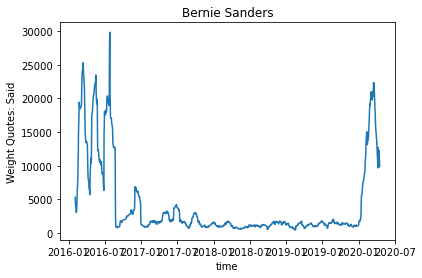

In [47]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Weight Quotes: Said')
plt.title('Bernie Sanders')

In [48]:
# We group weighted quotations (audience views) by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
views_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_views'].sum())
views_byelection.rename(columns = {'normalize_views': 'views_byelection'}, inplace=True)

Pearson coefficient: 0.6435547709593785, p value: 1.9785061665161968e-22


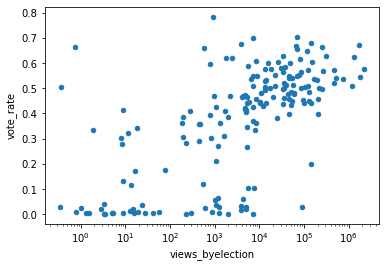

In [49]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
views_byelection['vote_rate'] = views_byelection.index.map(candidate_info_byname['vote_rate'])
views_vote = views_byelection.plot.scatter(x = 'views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(views_byelection['views_byelection']), views_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

We notice very little change on the pearson coefficient and p-value when comparing the result to section **1.4** (where we did not weigh the quotes by website views). Just applying the number of quotations is probably sufficient for clustering and prediction model.

## 3. Features for Prediction Model
In the proposal, we decide to build a model predicting election results based on quotation data. Here, we preprocess the quote data and candidate data to generate the features for training our model.

The first feature is the change of quotation number over time. We will also use this for clustering analysis in proposed question 3.

In [25]:
date_start=pd.to_datetime('2015-01-01', format='%Y-%m-%d') 
all_date = (pd.to_datetime('2020-12-31', format='%Y-%m-%d') - date_start).days # number of days.
candidate_quotes_name = candidate_quotes_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_feature = pd.DataFrame(np.zeros([all_date,len(candidate_quotes_name)]), columns=candidate_quotes_name) # initialize frequency vector

for candidate in candidate_quotes_name:
    candidate_mention = candidate_quotes_byday[candidate]
    for date in candidate_mention.index:
        date2days = (pd.to_datetime(date, format='%Y-%m-%d') - date_start).days # convert date to num of days w.r.t. start date
        candidate_quotes_feature[candidate].iloc[date2days] = candidate_mention.loc[date]

We also include the party affiliation of each candidate. Moreover, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the election from 2016 to 2021, we will use the 2016 presidential election data for the senate election from 2016 to 2019, and use the 2020 presidential election data for the senate election from 2020 to 2021.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [27]:
# We load 2016 and 2020 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president20 = president[president['year'] == 2020].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3441,2016,COLORADO,CO,8,84,62,US PRESIDENT,"MATUREN, MICHAEL A.",AMERICAN SOLIDARITY PARTY,False,862,2780220,20210113,NaN,OTHER
3580,2016,MISSOURI,MO,29,43,34,US PRESIDENT,NaN,NaN,True,7156,2808605,20210113,NaN,OTHER
3623,2016,NEW YORK,NY,36,21,13,US PRESIDENT,"TRUMP, DONALD J.",CONSERVATIVE,False,292392,7802084,20210113,NaN,OTHER
3530,2016,MAINE,ME,23,11,2,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,335593,771892,20210113,NaN,REPUBLICAN


In [28]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
president20['vote_rate'] = president20['candidatevotes']/president20['totalvotes']

In [29]:
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty20 = president20.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [30]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
features = candidate_info_byname[['party_simplified', 'vote_rate']].copy()
for name in features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if candidate_info_byname.loc[name, 'year'] < 2020: #for candidate before 2020
        if party_ in vote_byparty16[state_].index:  #check whether the affiliated party in recent president election
            features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0
    else:
        if party_ in vote_byparty20[state_].index: 
            features.loc[name, 'party_vote_rate'] = vote_byparty20[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0

In [31]:
features.sample(4)

,party_simplified,vote_rate,party_vote_rate
candidate,,,
RAY J. WRITZ,OTHER,0.061385,0.091421
PAUL STANTON,LIBERTARIAN,0.021174,0.021979
JOSH HAWLEY,REPUBLICAN,0.513832,0.567723
DEBORAH K. ROSS,DEMOCRAT,0.453657,0.461729


# 4. statistics of sentence complexity

We also calculated the average length of sentence and word of each quotation. This information may be used in our analysis about speech style (question 6).

In [32]:
# calculate average sentence length (by word number)
import re
candidate_quotes['split_quotation']=candidate_quotes.quotation.map(lambda x:re.split(r'\.|!|\?',x))
candidate_quotes['split_quotation']=candidate_quotes.split_quotation.map(lambda x:list(filter(None, x))) # remove empty string
candidate_quotes['avg_sentence_length'] = candidate_quotes.split_quotation.map(lambda x:np.mean(list(map(lambda s:len(s.split()), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000


In [33]:
# calculate average word lenghth for each quotation
candidate_quotes['split_words'] = candidate_quotes.quotation.map(lambda x:x.split())
candidate_quotes['avg_word_length'] = candidate_quotes.split_words.map(lambda x:np.mean(list(map(lambda w:len(w), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length,split_words,avg_word_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000,"[..., a, great, day, for, veterans, here, in, ...",4.318182
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333,"[', It, is, not, now,, nor, has, it, ever, bee...",3.931507
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000,"[[, My, dad, ], saw, what, a, great, opportuni...",3.363636
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000,"[hurt, Michigan, workers, and, cost, thousands...",6.300000
